## Setup & Imports

In [1]:
import sys
sys.path.insert(0, "..")

import time
import json
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Our modules
from src.agents.dqn_agent import DQNAgent
from src.environment.gym_env import InventoryEnvironment
from src.mdp import RewardFunction, State
from src.agents.callbacks.learning_curve_callback import LearningCurveCallback
from src.agents.metrics import TrainingMetrics, EvaluationMetrics
from src.seeds import generate_seeds

# Plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 4)

# Initialize plot classes
training_plots = TrainingMetrics()
evaluation_plots = EvaluationMetrics()

print("✅ All imports successful!")

✅ All imports successful!


## 1. Experiment Configuration Classes

In [2]:
@dataclass
class EnvironmentConfig:
    """Environment configuration."""
    k: int = 30
    Q_max: int = 40
    episode_length: int = 365
    name: str = "default"
    
    def __str__(self):
        return f"k{self.k}_Qmax{self.Q_max}_ep{self.episode_length}"

@dataclass
class AgentConfig:
    """Agent hyperparameter configuration."""
    learning_rate: float = 1e-4
    gamma: float = 0.99
    buffer_size: int = 100_000
    batch_size: int = 64
    exploration_fraction: float = 0.3
    exploration_final_eps: float = 0.05
    target_update_interval: int = 1000
    learning_starts: int = 1000
    train_freq: int = 4
    net_arch: List[int] = None # type: ignore
    name: str = "default"
    
    def __post_init__(self):
        if self.net_arch is None:
            self.net_arch = [256, 256]
    
    def __str__(self):
        return f"lr{self.learning_rate}_g{self.gamma}_arch{'x'.join(map(str, self.net_arch))}"

@dataclass
class ExperimentConfig:
    """Complete experiment configuration."""
    env_config: EnvironmentConfig
    agent_config: AgentConfig
    total_timesteps: int = 1_000_000
    experiment_name: Optional[str] = None
    
    def __post_init__(self):
        if self.experiment_name is None:
            self.experiment_name = f"{self.env_config}_{self.agent_config}"
    
    def to_dict(self) -> Dict:
        """Convert to dictionary for saving."""
        return {
            "environment": {
                "k": self.env_config.k,
                "Q_max": self.env_config.Q_max,
                "episode_length": self.env_config.episode_length,
            },
            "agent": {
                "learning_rate": self.agent_config.learning_rate,
                "gamma": self.agent_config.gamma,
                "buffer_size": self.agent_config.buffer_size,
                "batch_size": self.agent_config.batch_size,
                "exploration_fraction": self.agent_config.exploration_fraction,
                "exploration_final_eps": self.agent_config.exploration_final_eps,
                "target_update_interval": self.agent_config.target_update_interval,
                "learning_starts": self.agent_config.learning_starts,
                "train_freq": self.agent_config.train_freq,
                "net_arch": self.agent_config.net_arch,
            },
            "training": {
                "total_timesteps": self.total_timesteps,
            },
            "experiment_name": self.experiment_name,
        }

print("✅ Configuration classes defined")

✅ Configuration classes defined


## 2. Define Experiments

Configure all experiments you want to run. Each experiment tests a specific hypothesis:
- How does frame stacking (k) affect performance?
- What's the optimal learning rate?
- Does gamma (discount factor) matter?
- Do we need a larger network?

In [3]:
# Define experiments to run
experiments = [
    # Baseline
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(learning_rate=1e-4, gamma=0.99, name="baseline"),
        total_timesteps=3_000_000,
        experiment_name="baseline",
    ),
    # Test different frame stacking (k)
    ExperimentConfig(
        env_config=EnvironmentConfig(k=15, Q_max=40, name="k15"),
        agent_config=AgentConfig(learning_rate=1e-4, gamma=0.99, name="baseline"),
        total_timesteps=3_000_000,
        experiment_name="k15_baseline_agent",
    ),
    ExperimentConfig(
        env_config=EnvironmentConfig(k=25, Q_max=40, name="k25"),
        agent_config=AgentConfig(learning_rate=1e-4, gamma=0.99, name="baseline"),
        total_timesteps=3_000_000,
        experiment_name="k25_baseline_agent",
    ),
    # Test different Q_max
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=30, name="Qmax30"),
        agent_config=AgentConfig(learning_rate=1e-4, gamma=0.99, name="baseline"),
        total_timesteps=3_000_000,
        experiment_name="Qmax30_baseline_agent",
    ),
    # Test different learning rates
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(learning_rate=3e-4, gamma=0.99, name="lr3e-4"),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_lr3e-4",
    ),
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(learning_rate=1e-5, gamma=0.99, name="lr1e-5"),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_lr1e-5",
    ),
    # Test different gamma (discount factor)
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(learning_rate=1e-4, gamma=0.95, name="gamma0.95"),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_gamma0.95",
    ),
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(learning_rate=1e-4, gamma=0.999, name="gamma0.999"),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_gamma0.999",
    ),
    # Test larger network
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(
            learning_rate=1e-4, gamma=0.99, net_arch=[512, 512], name="net512x512"
        ),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_net512x512",
    ),
    # Test less training freq
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(
            learning_rate=1e-4, gamma=0.99, train_freq=2, name="trainfreq2"
        ),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_trainfreq2",
    ),
    ExperimentConfig(
        env_config=EnvironmentConfig(k=30, Q_max=40, name="baseline"),
        agent_config=AgentConfig(
            learning_rate=1e-4, gamma=0.99, train_freq=1, name="trainfreq1"
        ),
        total_timesteps=3_000_000,
        experiment_name="baseline_env_trainfreq1",
    ),
]

print(f"📋 Configured {len(experiments)} experiments:")
for i, exp in enumerate(experiments, 1):
    print(f"   {i}. {exp.experiment_name}")
    print(f"      Env: k={exp.env_config.k}, Q_max={exp.env_config.Q_max}")
    print(
        f"      Agent: lr={exp.agent_config.learning_rate}, γ={exp.agent_config.gamma}, arch={exp.agent_config.net_arch}"
    )
    print()

📋 Configured 11 experiments:
   1. baseline
      Env: k=30, Q_max=40
      Agent: lr=0.0001, γ=0.99, arch=[256, 256]

   2. k15_baseline_agent
      Env: k=15, Q_max=40
      Agent: lr=0.0001, γ=0.99, arch=[256, 256]

   3. k25_baseline_agent
      Env: k=25, Q_max=40
      Agent: lr=0.0001, γ=0.99, arch=[256, 256]

   4. Qmax30_baseline_agent
      Env: k=30, Q_max=30
      Agent: lr=0.0001, γ=0.99, arch=[256, 256]

   5. baseline_env_lr3e-4
      Env: k=30, Q_max=40
      Agent: lr=0.0003, γ=0.99, arch=[256, 256]

   6. baseline_env_lr1e-5
      Env: k=30, Q_max=40
      Agent: lr=1e-05, γ=0.99, arch=[256, 256]

   7. baseline_env_gamma0.95
      Env: k=30, Q_max=40
      Agent: lr=0.0001, γ=0.95, arch=[256, 256]

   8. baseline_env_gamma0.999
      Env: k=30, Q_max=40
      Agent: lr=0.0001, γ=0.999, arch=[256, 256]

   9. baseline_env_net512x512
      Env: k=30, Q_max=40
      Agent: lr=0.0001, γ=0.99, arch=[512, 512]

   10. baseline_env_trainfreq2
      Env: k=30, Q_max=40
     

In [4]:
# Seeds for reproducibility
TRAINING_SEED = generate_seeds(1, start_index=20)[0]
EVAL_SEEDS = generate_seeds(100, start_index=100)

experiments_to_run = experiments
print(f"🎯 Running all {len(experiments_to_run)} experiments:")

for exp in experiments_to_run:
    print(f"   • {exp.experiment_name}")

print(f"\n🎲 Seeds:")
print(f"   Training: {TRAINING_SEED}")
print(f"   Evaluation: {len(EVAL_SEEDS)} seeds starting at {EVAL_SEEDS[0]}")

🎯 Running all 11 experiments:
   • baseline
   • k15_baseline_agent
   • k25_baseline_agent
   • Qmax30_baseline_agent
   • baseline_env_lr3e-4
   • baseline_env_lr1e-5
   • baseline_env_gamma0.95
   • baseline_env_gamma0.999
   • baseline_env_net512x512
   • baseline_env_trainfreq2
   • baseline_env_trainfreq1

🎲 Seeds:
   Training: 6173
   Evaluation: 100 seeds starting at 2216


## 4. Training Loop

Train all selected experiments sequentially. Each experiment:
1. Creates environment with specified config
2. Creates agent with specified hyperparameters
3. Trains for specified timesteps
4. Saves model and configuration
5. Records learning curve and training time

In [5]:
# Storage for all experiment results
all_results = {}

for exp_idx, exp_config in enumerate(experiments_to_run, 1):
    print("=" * 80)
    print(f"🚀 EXPERIMENT {exp_idx}/{len(experiments_to_run)}: {exp_config.experiment_name}")
    print("=" * 80)
    
    # Create environment
    env = InventoryEnvironment(
        k=exp_config.env_config.k,
        Q_max=exp_config.env_config.Q_max,
        episode_length=exp_config.env_config.episode_length,
        random_seed=TRAINING_SEED,
    )
    print(f"✅ Environment: {env}")
    
    # Create agent
    agent = DQNAgent(
        env=env,
        learning_rate=exp_config.agent_config.learning_rate,
        gamma=exp_config.agent_config.gamma,
        buffer_size=exp_config.agent_config.buffer_size,
        batch_size=exp_config.agent_config.batch_size,
        exploration_fraction=exp_config.agent_config.exploration_fraction,
        exploration_final_eps=exp_config.agent_config.exploration_final_eps,
        target_update_interval=exp_config.agent_config.target_update_interval,
        learning_starts=exp_config.agent_config.learning_starts,
        train_freq=exp_config.agent_config.train_freq,
        tensorboard_log=None,
        policy_kwargs=dict(net_arch=exp_config.agent_config.net_arch),
        seed=TRAINING_SEED,
        verbose=0,
    )
    print(f"✅ Agent: lr={exp_config.agent_config.learning_rate}, γ={exp_config.agent_config.gamma}, net={exp_config.agent_config.net_arch}")
    
    # Train
    print(f"\n⏳ Training for {exp_config.total_timesteps:,} timesteps (~{exp_config.total_timesteps // exp_config.env_config.episode_length} episodes)...")
    start_time = time.time()
    
    learning_curve_callback = LearningCurveCallback()
    agent.train(
        total_timesteps=exp_config.total_timesteps,
        progress_bar=True,
        callbacks=learning_curve_callback,
    )
    
    training_time = time.time() - start_time
    print(f"✅ Training complete in {training_time/60:.1f} minutes")
    
    # Save agent with unique name
    model_path = f"./models/dqn_{exp_config.experiment_name}"
    agent.model.save(model_path)
    print(f"💾 Model saved: {model_path}")
    
    # Save configuration
    config_path = f"./models/config_{exp_config.experiment_name}.json"
    Path(config_path).parent.mkdir(parents=True, exist_ok=True)
    with open(config_path, 'w') as f:
        json.dump(exp_config.to_dict(), f, indent=2)
    print(f"💾 Config saved: {config_path}")
    
    # Store results
    all_results[exp_config.experiment_name] = {
        "config": exp_config,
        "agent": agent,
        "learning_curve": {
            "episode_timesteps": learning_curve_callback.episode_timesteps,
            "episode_rewards": learning_curve_callback.episode_rewards,
        },
        "training_time": training_time,
        "model_path": model_path,
    }
    
    print(f"✅ Experiment {exp_idx} complete!\n")

print("=" * 80)
print(f"🎉 ALL {len(experiments_to_run)} EXPERIMENTS COMPLETE!")
print("=" * 80)

🚀 EXPERIMENT 1/11: baseline
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)


Output()

✅ Agent: lr=0.0001, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 45.8 minutes
💾 Model saved: ./models/dqn_baseline
💾 Config saved: ./models/config_baseline.json
✅ Experiment 1 complete!

🚀 EXPERIMENT 2/11: k15_baseline_agent
✅ Environment: Inventory Management Gym Environment (k=15, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 43.7 minutes
💾 Model saved: ./models/dqn_k15_baseline_agent
💾 Config saved: ./models/config_k15_baseline_agent.json
✅ Experiment 2 complete!

🚀 EXPERIMENT 3/11: k25_baseline_agent
✅ Environment: Inventory Management Gym Environment (k=25, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 44.5 minutes
💾 Model saved: ./models/dqn_k25_baseline_agent
💾 Config saved: ./models/config_k25_baseline_agent.json
✅ Experiment 3 complete!

🚀 EXPERIMENT 4/11: Qmax30_baseline_agent
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=30, episode_length=365)
✅ Agent: lr=0.0001, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 38.5 minutes
💾 Model saved: ./models/dqn_Qmax30_baseline_agent
💾 Config saved: ./models/config_Qmax30_baseline_agent.json
✅ Experiment 4 complete!

🚀 EXPERIMENT 5/11: baseline_env_lr3e-4
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=0.0003, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 45.1 minutes
💾 Model saved: ./models/dqn_baseline_env_lr3e-4
💾 Config saved: ./models/config_baseline_env_lr3e-4.json
✅ Experiment 5 complete!

🚀 EXPERIMENT 6/11: baseline_env_lr1e-5
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=1e-05, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 45.0 minutes
💾 Model saved: ./models/dqn_baseline_env_lr1e-5
💾 Config saved: ./models/config_baseline_env_lr1e-5.json
✅ Experiment 6 complete!

🚀 EXPERIMENT 7/11: baseline_env_gamma0.95
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.95, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 44.9 minutes
💾 Model saved: ./models/dqn_baseline_env_gamma0.95
💾 Config saved: ./models/config_baseline_env_gamma0.95.json
✅ Experiment 7 complete!

🚀 EXPERIMENT 8/11: baseline_env_gamma0.999
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.999, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 44.9 minutes
💾 Model saved: ./models/dqn_baseline_env_gamma0.999
💾 Config saved: ./models/config_baseline_env_gamma0.999.json
✅ Experiment 8 complete!

🚀 EXPERIMENT 9/11: baseline_env_net512x512
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.99, net=[512, 512]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 71.2 minutes
💾 Model saved: ./models/dqn_baseline_env_net512x512
💾 Config saved: ./models/config_baseline_env_net512x512.json
✅ Experiment 9 complete!

🚀 EXPERIMENT 10/11: baseline_env_trainfreq2
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


Output()

✅ Training complete in 78.6 minutes
💾 Model saved: ./models/dqn_baseline_env_trainfreq2
💾 Config saved: ./models/config_baseline_env_trainfreq2.json
✅ Experiment 10 complete!

🚀 EXPERIMENT 11/11: baseline_env_trainfreq1
✅ Environment: Inventory Management Gym Environment (k=30, Q_max=40, episode_length=365)
✅ Agent: lr=0.0001, γ=0.99, net=[256, 256]

⏳ Training for 3,000,000 timesteps (~8219 episodes)...


✅ Training complete in 147.7 minutes
💾 Model saved: ./models/dqn_baseline_env_trainfreq1
💾 Config saved: ./models/config_baseline_env_trainfreq1.json
✅ Experiment 11 complete!

🎉 ALL 11 EXPERIMENTS COMPLETE!


## 5. Training Analysis

Compare learning curves across all experiments.

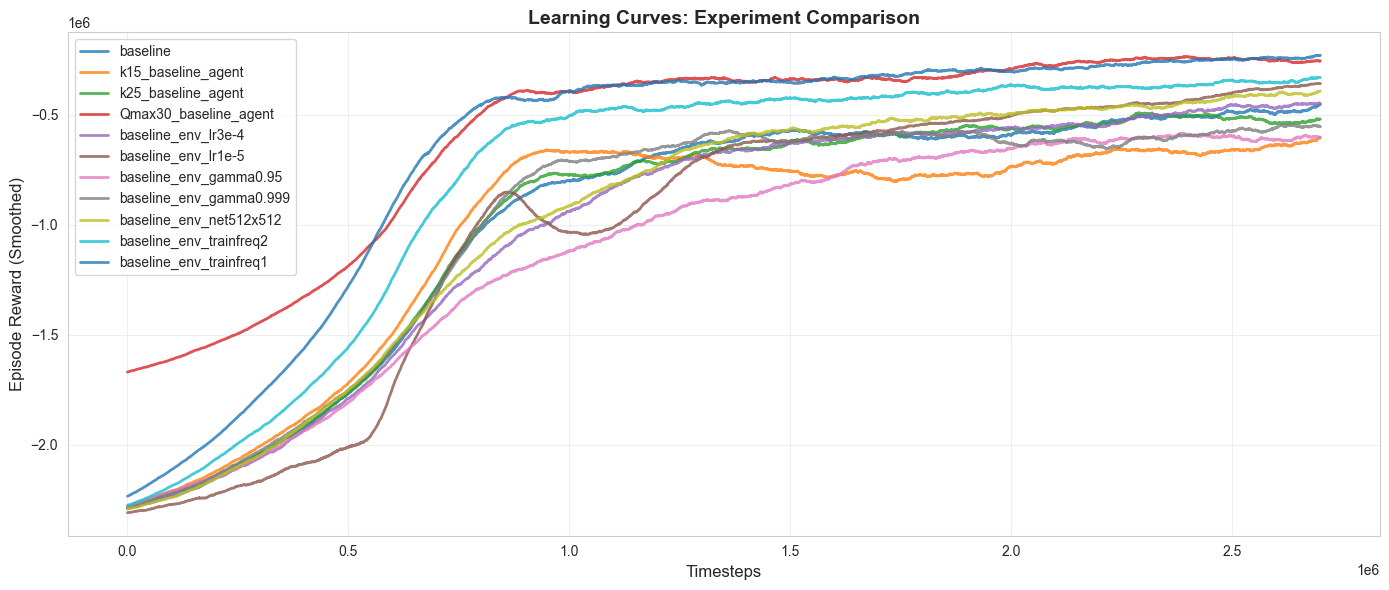

📊 TRAINING SUMMARY

baseline:
  Training time: 45.8 min
  Final episode reward: -46659.00
  Mean last 100 episodes: -337952.00

k15_baseline_agent:
  Training time: 43.7 min
  Final episode reward: -39426.00
  Mean last 100 episodes: -578193.94

k25_baseline_agent:
  Training time: 44.5 min
  Final episode reward: -30503.00
  Mean last 100 episodes: -428947.41

Qmax30_baseline_agent:
  Training time: 38.5 min
  Final episode reward: -28423.00
  Mean last 100 episodes: -183459.56

baseline_env_lr3e-4:
  Training time: 45.1 min
  Final episode reward: -29150.00
  Mean last 100 episodes: -416317.44

baseline_env_lr1e-5:
  Training time: 45.0 min
  Final episode reward: -553912.00
  Mean last 100 episodes: -318445.97

baseline_env_gamma0.95:
  Training time: 44.9 min
  Final episode reward: -146368.00
  Mean last 100 episodes: -641215.62

baseline_env_gamma0.999:
  Training time: 44.9 min
  Final episode reward: -1345233.00
  Mean last 100 episodes: -538102.00

baseline_env_net512x512:
  T

In [6]:
# Plot learning curves for all experiments
fig, ax = plt.subplots(figsize=(14, 6))

for exp_name, results in all_results.items():
    lc = results["learning_curve"]
    
    # Smooth the curve
    window = max(5, int(0.1 * len(lc["episode_rewards"])))
    smoothed = np.convolve(lc["episode_rewards"], np.ones(window)/window, mode='valid')
    smoothed_steps = lc["episode_timesteps"][:len(smoothed)]
    
    ax.plot(smoothed_steps, smoothed, linewidth=2, label=exp_name, alpha=0.8)

ax.set_xlabel("Timesteps", fontsize=12)
ax.set_ylabel("Episode Reward (Smoothed)", fontsize=12)
ax.set_title("Learning Curves: Experiment Comparison", fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print training summary
print("=" * 80)
print("📊 TRAINING SUMMARY")
print("=" * 80)
for exp_name, results in all_results.items():
    final_reward = results["learning_curve"]["episode_rewards"][-1]
    mean_last_100 = np.mean(results["learning_curve"]["episode_rewards"][-100:])
    print(f"\n{exp_name}:")
    print(f"  Training time: {results['training_time']/60:.1f} min")
    print(f"  Final episode reward: {final_reward:.2f}")
    print(f"  Mean last 100 episodes: {mean_last_100:.2f}")

## 6. Evaluation

Evaluate all trained agents on 100 independent test episodes.

In [31]:
# Evaluate all experiments
all_evaluation_results = {}
reward_fn = RewardFunction()

for exp_name, results in all_results.items():
    print(f"\n🧪 Evaluating: {exp_name}")
    
    exp_config = results["config"]
    agent = results["agent"]
    
    test_episodes = []
    
    for ep, seed in enumerate(EVAL_SEEDS):
        if (ep + 1) % 25 == 0:
            print(f"  Episode {ep + 1}/{len(EVAL_SEEDS)}...")
        
        # Create evaluation environment with same config as training
        eval_env = InventoryEnvironment(
            k=exp_config.env_config.k,
            Q_max=exp_config.env_config.Q_max,
            episode_length=1000,
            random_seed=seed,
        )
        
        obs, _ = eval_env.reset()
        
        ep_data = {
            "net_inv_0": [],
            "net_inv_1": [],
            "q0": [],
            "q1": [],
            "demand_0": [],
            "demand_1": [],
            "ordering_cost": [],
            "holding_cost": [],
            "shortage_cost": [],
            "total_daily_cost": [],
        }
        
        done = False
        while not done:
            action = agent.select_action(obs, deterministic=True)
            action_obj = eval_env.action_space_config.get_action(action)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            
            # Log data
            ep_data["net_inv_0"].append(info["net_inventory"][0])
            ep_data["net_inv_1"].append(info["net_inventory"][1])
            ep_data["q0"].append(action_obj.order_quantities[0])
            ep_data["q1"].append(action_obj.order_quantities[1])
            ep_data["demand_0"].append(info["total_demand"][0])
            ep_data["demand_1"].append(info["total_demand"][1])
            
            state = eval_env.get_current_state()
            costs = reward_fn.calculate_costs(state, action_obj)
            
            ep_data["ordering_cost"].append(costs.ordering_cost)
            ep_data["holding_cost"].append(costs.holding_cost)
            ep_data["shortage_cost"].append(costs.shortage_cost)
            ep_data["total_daily_cost"].append(costs.total_cost)
            
            done = terminated or truncated
        
        test_episodes.append(ep_data)
    
    # Store evaluation results
    all_evaluation_results[exp_name] = {
        "test_episodes": test_episodes,
        "config": exp_config,
    }
    
    # Quick stats
    total_costs = [sum(ep["total_daily_cost"]) for ep in test_episodes]
    mean_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    print(f"  ✅ Mean episode cost: ${mean_cost:.2f} ± ${std_cost:.2f}")

print("\n✅ All evaluations complete!")


🧪 Evaluating: baseline
  Episode 25/100...
  Episode 50/100...
  Episode 75/100...
  Episode 100/100...
  ✅ Mean episode cost: $1773700.15 ± $3566470.81

🧪 Evaluating: k15_baseline_agent
  Episode 25/100...
  Episode 50/100...
  Episode 75/100...
  Episode 100/100...
  ✅ Mean episode cost: $10268510.16 ± $2176092.03

🧪 Evaluating: k25_baseline_agent
  Episode 25/100...
  Episode 50/100...
  Episode 75/100...
  Episode 100/100...
  ✅ Mean episode cost: $16865123.25 ± $821303.87

🧪 Evaluating: Qmax30_baseline_agent
  Episode 25/100...
  Episode 50/100...
  Episode 75/100...
  Episode 100/100...
  ✅ Mean episode cost: $249599.84 ± $937903.21

🧪 Evaluating: baseline_env_lr3e-4
  Episode 25/100...
  Episode 50/100...
  Episode 75/100...
  Episode 100/100...
  ✅ Mean episode cost: $1315970.59 ± $3260586.70

🧪 Evaluating: baseline_env_lr1e-5
  Episode 25/100...
  Episode 50/100...
  Episode 75/100...
  Episode 100/100...
  ✅ Mean episode cost: $13489163.10 ± $2184948.18

🧪 Evaluating: baseli

## 7. Comparison Results

Compare all experiments side-by-side.

In [32]:
# Create comparison table
comparison_data = []

for exp_name, eval_results in all_evaluation_results.items():
    test_eps = eval_results["test_episodes"]
    config = eval_results["config"]
    
    # Calculate metrics
    episode_costs = [sum(ep["total_daily_cost"]) for ep in test_eps]
    mean_cost = np.mean(episode_costs)
    std_cost = np.std(episode_costs)
    min_cost = np.min(episode_costs)
    max_cost = np.max(episode_costs)
    
    # Calculate average cost components (across all episodes and days)
    all_ordering = [cost for ep in test_eps for cost in ep["ordering_cost"]]
    all_holding = [cost for ep in test_eps for cost in ep["holding_cost"]]
    all_shortage = [cost for ep in test_eps for cost in ep["shortage_cost"]]
    
    comparison_data.append({
        "Experiment": exp_name,
        "k": config.env_config.k,
        "Q_max": config.env_config.Q_max,
        "LR": config.agent_config.learning_rate,
        "Gamma": config.agent_config.gamma,
        "Network": f"{config.agent_config.net_arch[0]}x{config.agent_config.net_arch[1]}",
        "Mean Cost": mean_cost,
        "Std Cost": std_cost,
        "Min Cost": min_cost,
        "Max Cost": max_cost,
        "Avg Ordering": np.mean(all_ordering),
        "Avg Holding": np.mean(all_holding),
        "Avg Shortage": np.mean(all_shortage),
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison = df_comparison.sort_values("Mean Cost")

print("=" * 120)
print("📊 EXPERIMENT COMPARISON (sorted by Mean Cost)")
print("=" * 120)
print(df_comparison.to_string(index=False))
print("\n")

# Find best experiment
best_exp = df_comparison.iloc[0]
print(f"🏆 BEST PERFORMER: {best_exp['Experiment']}")
print(f"   Mean Episode Cost: ${best_exp['Mean Cost']:.2f} ± ${best_exp['Std Cost']:.2f}")
print(f"   Configuration: k={best_exp['k']}, Q_max={best_exp['Q_max']}, lr={best_exp['LR']}, γ={best_exp['Gamma']}")

# Save comparison to CSV
comparison_path = "../results/dqn_experiments_comparison.csv"
Path(comparison_path).parent.mkdir(parents=True, exist_ok=True)
df_comparison.to_csv(comparison_path, index=False)
print(f"\n💾 Comparison saved: {comparison_path}")

📊 EXPERIMENT COMPARISON (sorted by Mean Cost)
             Experiment  k  Q_max      LR  Gamma Network   Mean Cost     Std Cost   Min Cost   Max Cost  Avg Ordering  Avg Holding  Avg Shortage
baseline_env_trainfreq2 30     40 0.00010  0.990 256x256   105842.03 7.959521e+03    88040.0   123984.0      11.52055      9.48659      84.83489
baseline_env_trainfreq1 30     40 0.00010  0.990 256x256   247185.90 1.404173e+06    69912.0 14107964.0      11.11493    175.23789      60.83308
  Qmax30_baseline_agent 30     30 0.00010  0.990 256x256   249599.84 9.379032e+05    78129.0  8440639.0      13.63800    170.87073      65.09111
baseline_env_net512x512 30     40 0.00010  0.990 512x512  1201237.07 3.109873e+06    84854.0 19823236.0      24.39921   1108.37905      68.45881
    baseline_env_lr3e-4 30     40 0.00030  0.990 256x256  1315970.59 3.260587e+06    85157.0 15838037.0      25.22931   1218.71009      72.03119
               baseline 30     40 0.00010  0.990 256x256  1773700.15 3.566471e+06   

## 8. Visualization Dashboard

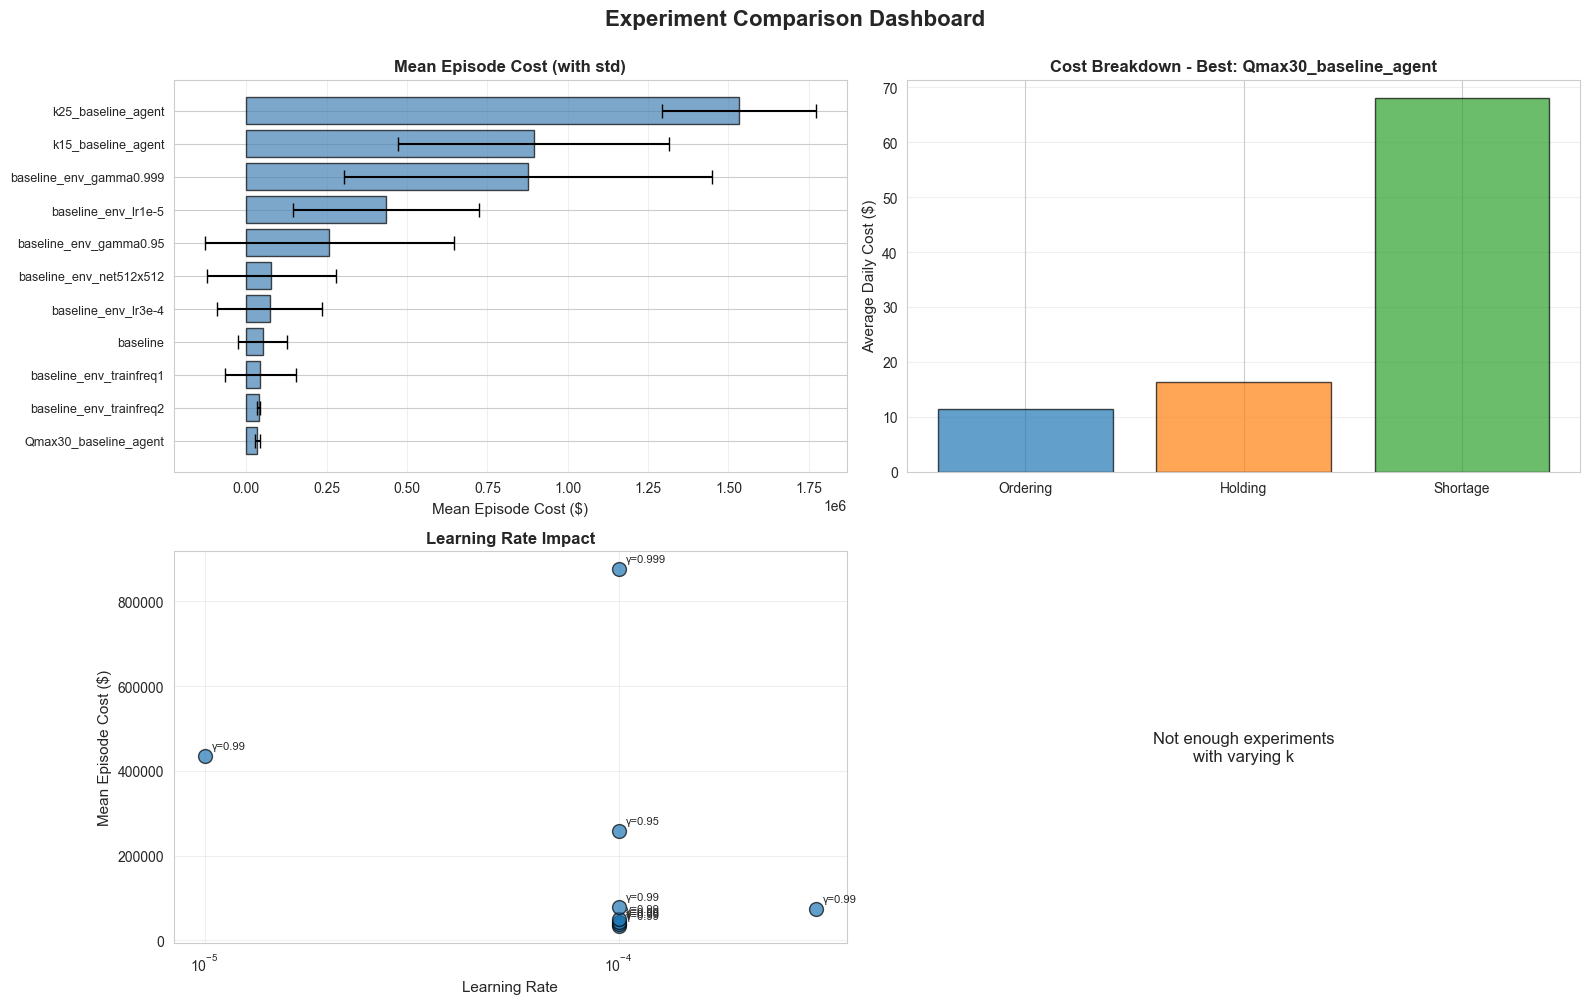

In [25]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Mean cost comparison
ax = axes[0, 0]
exp_names = df_comparison["Experiment"].values
mean_costs = df_comparison["Mean Cost"].values
std_costs = df_comparison["Std Cost"].values

bars = ax.barh(range(len(exp_names)), mean_costs, xerr=std_costs, 
               capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
ax.set_yticks(range(len(exp_names)))
ax.set_yticklabels(exp_names, fontsize=9)
ax.set_xlabel("Mean Episode Cost ($)", fontsize=11)
ax.set_title("Mean Episode Cost (with std)", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# 2. Cost component breakdown (for best performer)
ax = axes[0, 1]
best_exp_name = df_comparison.iloc[0]["Experiment"]
best_ordering = df_comparison.iloc[0]["Avg Ordering"]
best_holding = df_comparison.iloc[0]["Avg Holding"]
best_shortage = df_comparison.iloc[0]["Avg Shortage"]

components = ['Ordering', 'Holding', 'Shortage']
values = [best_ordering, best_holding, best_shortage]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

ax.bar(components, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel("Average Daily Cost ($)", fontsize=11)
ax.set_title(f"Cost Breakdown - Best: {best_exp_name}", fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 3. Learning rate impact
ax = axes[1, 0]
lr_experiments = df_comparison[df_comparison["k"] == df_comparison.iloc[0]["k"]]
if len(lr_experiments) > 1:
    ax.scatter(lr_experiments["LR"], lr_experiments["Mean Cost"], 
               s=100, alpha=0.7, edgecolors='black')
    for _, row in lr_experiments.iterrows():
        ax.annotate(f"γ={row['Gamma']}", 
                   (row["LR"], row["Mean Cost"]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax.set_xlabel("Learning Rate", fontsize=11)
    ax.set_ylabel("Mean Episode Cost ($)", fontsize=11)
    ax.set_xscale('log')
    ax.set_title("Learning Rate Impact", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, "Not enough experiments\nwith varying LR", 
            ha='center', va='center', fontsize=12)
    ax.axis('off')

# 4. Environment config impact (k)
ax = axes[1, 1]
k_experiments = df_comparison[df_comparison["Q_max"] == df_comparison.iloc[0]["Q_max"]]
if len(k_experiments) > 1:
    ax.scatter(k_experiments["k"], k_experiments["Mean Cost"], 
               s=100, alpha=0.7, edgecolors='black')
    for _, row in k_experiments.iterrows():
        ax.annotate(row["Experiment"].split('_')[0], 
                   (row["k"], row["Mean Cost"]),
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    ax.set_xlabel("Frame Stack Size (k)", fontsize=11)
    ax.set_ylabel("Mean Episode Cost ($)", fontsize=11)
    ax.set_title("Frame Stack Impact", fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, "Not enough experiments\nwith varying k", 
            ha='center', va='center', fontsize=12)
    ax.axis('off')

plt.suptitle("Experiment Comparison Dashboard", fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Detailed Analysis of Best Performer

Analyze the best-performing experiment in detail.

📊 Detailed Analysis: Qmax30_baseline_agent


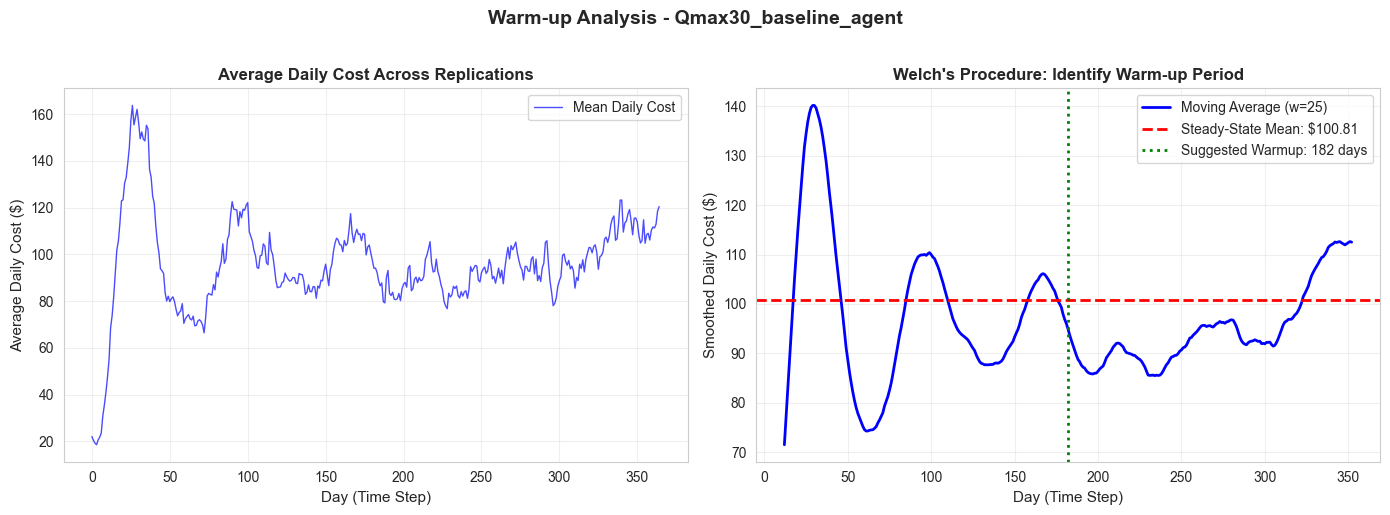

📊 Welch's Procedure Summary:
   Total replications: 100

✅ Suggested Warmup Length: 182 days
   (Detected where curve stays within 5% of steady-state)

💡 Tip: Visually verify the green line on the right plot.
   Adjust manually if needed based on your domain knowledge.


In [26]:
# Get best experiment data
best_exp_name = df_comparison.iloc[0]["Experiment"]
best_test_episodes = all_evaluation_results[best_exp_name]["test_episodes"]

print(f"📊 Detailed Analysis: {best_exp_name}")
print("=" * 80)

# Welch's procedure
n_days, n_reps, warmup_length = evaluation_plots.plot_welch_procedure(
    test_episodes=best_test_episodes,
    window_size=25,
    title=f"Warm-up Analysis - {best_exp_name}",
)

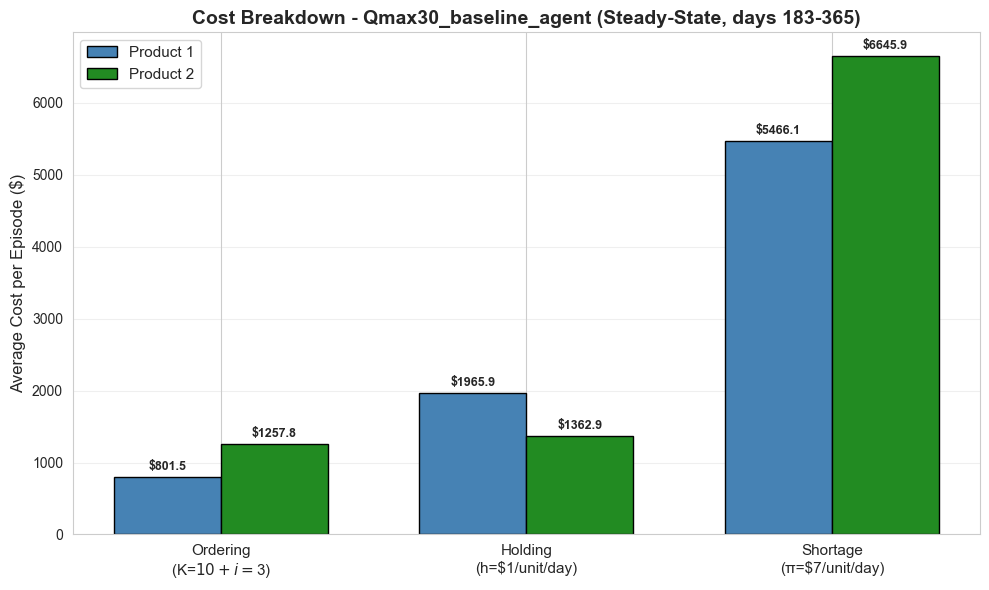

📊 Steady-State Average Cost per Episode (days 183-365):

  Product 1: $8233.45
    Ordering: $801.46 (9.7%)
    Holding:  $1965.90 (23.9%)
    Shortage: $5466.09 (66.4%)

  Product 2: $9266.48
    Ordering: $1257.75 (13.6%)
    Holding:  $1362.86 (14.7%)
    Shortage: $6645.87 (71.7%)

------------------------------------------------------------

  TOTAL: $17499.93


In [28]:
# Cost breakdown
evaluation_plots.plot_cost_breakdown_by_product(
    test_episodes=best_test_episodes,
    warmup_length=warmup_length,
    n_days=n_days,
    title=f"Cost Breakdown - {best_exp_name}",
)

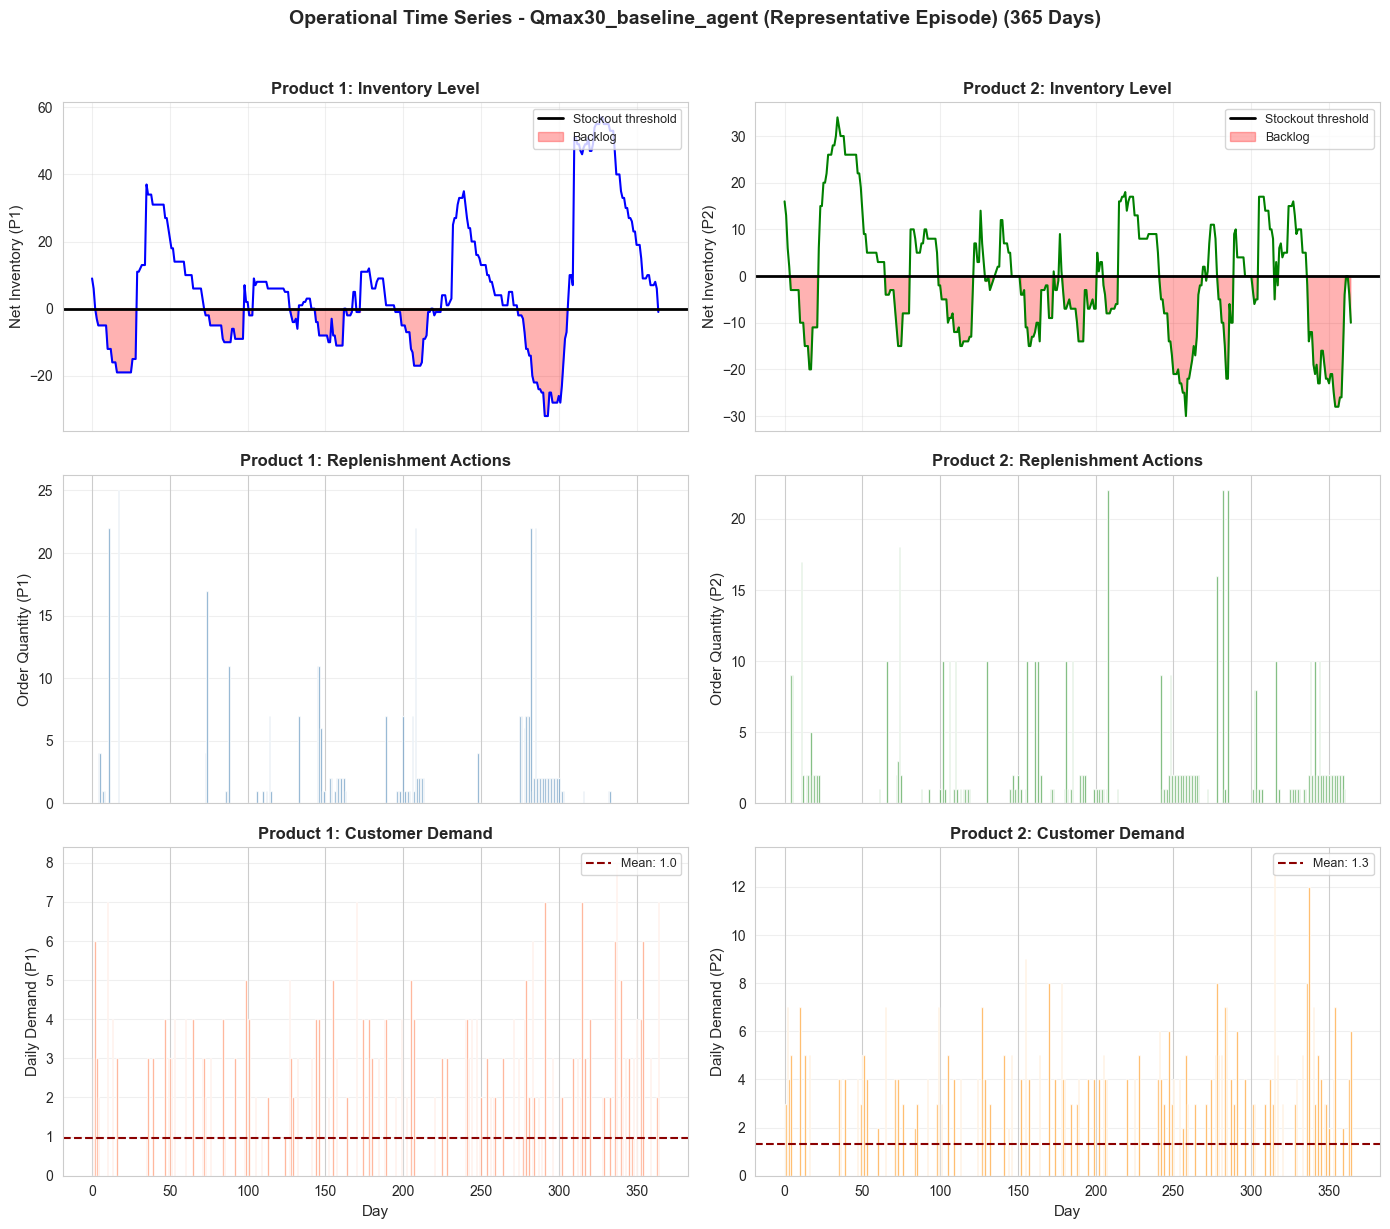

In [29]:
# Operational time series (representative episode)
episode_avg_costs = [np.mean(ep['total_daily_cost']) for ep in best_test_episodes]
global_mean_cost = np.mean(episode_avg_costs)
representative_idx = np.argmin(np.abs(np.array(episode_avg_costs) - global_mean_cost))

evaluation_plots.plot_operational_timeseries(
    episode_data=best_test_episodes[representative_idx],
    title=f"Operational Time Series - {best_exp_name} (Representative Episode)",
)

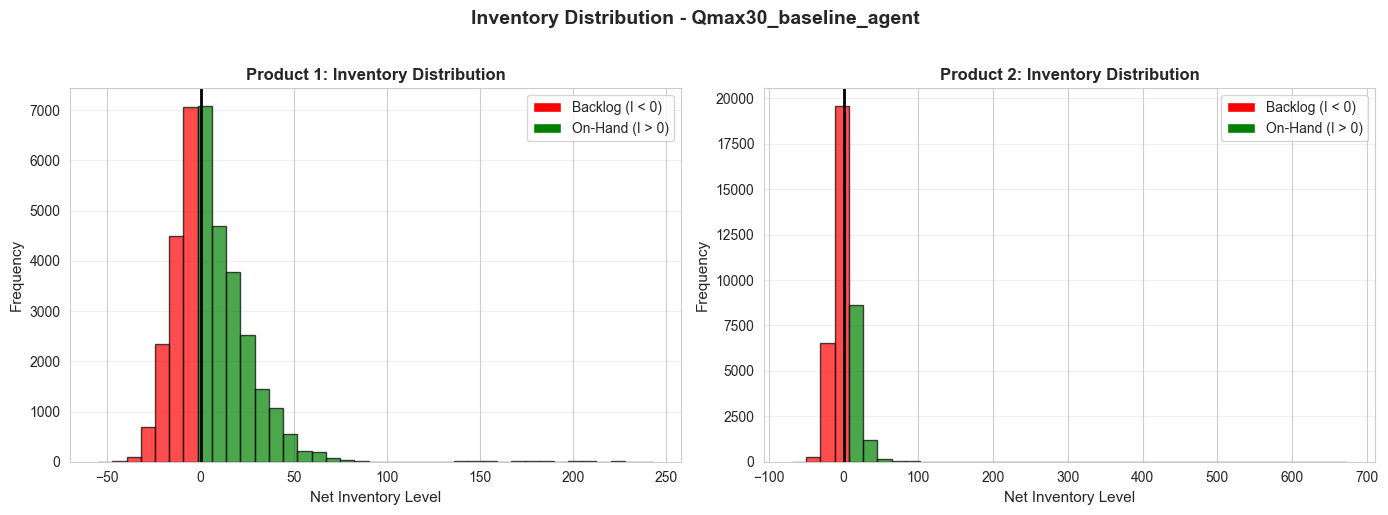

⚙️Service Level (% days without stockout):
  Product 1: 57.3%
  Product 2: 49.6%


In [30]:
# Inventory distribution
evaluation_plots.plot_inventory_histogram(
    test_episodes=best_test_episodes,
    title=f"Inventory Distribution - {best_exp_name}",
)

## Summary

All experiments have been trained, evaluated, and compared. Key outputs:

1. **Models**: Saved in `./models/dqn_<experiment_name>.zip`
2. **Configs**: Saved in `./models/config_<experiment_name>.json`
3. **Comparison CSV**: `../results/dqn_experiments_comparison.csv`
4. **Best performer**: Identified with detailed analysis

Use the best configuration for your final production model!